In [2]:
import os
import math
import time
import random
import itertools
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from tqdm.notebook import tqdm

In [3]:
# custom imports
import sys

sys.path.append(os.path.abspath(os.path.join('..', '..', 'utils')))

In [4]:
colors = [
    'blue', 'green', 'red', 'cyan', 'magenta',
    'yellow', 'black', 'orange', 'purple', 'brown',
    'pink', 'grey', 'maroon', 'gold', 'chocolate',
    'aqua', 'darkviolet', 'crimson', 'navy', 'darkgreen',
    'peru', 'tan', 'seagreen', 'darkslategrey', 'teal'
]

In [5]:
# constants
A = 3e-4
use_sin = True

## First let's try to detect the helical trajectory (for the x-y plane) in a single-particle file

In [6]:
# Get all the "Hits" data files
root_dir = os.path.join('..', '..', '..', 'data', 'pdg13-n1-1GeV-0.5eta')
hit_files = sorted([file for file in os.listdir(root_dir) if file.endswith("-hits.csv")])
initial_files = sorted([file for file in os.listdir(root_dir) if file.endswith("-particles_initial.csv")])
final_files = sorted([file for file in os.listdir(root_dir) if file.endswith("-particles_final.csv")])
dfs = [pd.read_csv(os.path.join(root_dir, file)) for file in hit_files]
initial_dfs = [pd.read_csv(os.path.join(root_dir, file), dtype={'particle_id':str, 'geometry_id': str})
               for file in initial_files]
final_dfs = [pd.read_csv(os.path.join(root_dir, file), dtype={'particle_id':str, 'geometry_id': str})
             for file in final_files]

In [25]:
random.seed(8392)
random_event = random.choice(range(0, len(dfs)))
print(f'Event chosen: {hit_files[random_event]}')
df = dfs[random_event]
initial_df = initial_dfs[random_event]
final_df = final_dfs[random_event]
df['weight'] = 1.0
df['r'] = np.sqrt(np.square(df['tx']) + np.square(df['ty']))
df['phi'] = np.arctan2(df['ty'], df['tx'])
df['xy_track'] = df[['r','phi']].apply(lambda pair: (pair[0], pair[1]), 1)
df['rz_track'] = df[['r','tz']].apply(lambda pair: (pair[0], pair[1]), 1)
df.head()

Event chosen: event000000028-hits.csv


,particle_id,geometry_id,tx,ty,tz,tt,tpx,tpy,tpz,te,deltapx,deltapy,deltapz,deltae,index,weight,r,phi,xy_track,rz_track
0,4503599644147712,936748859932016707,-3.331429,-32.588665,-14.162692,0.119606,-0.091922,-0.995766,-0.432329,1.094565,0,0,0,0,0,1.0,32.758503,-1.672669,"(32.75850275169369, -1.6726690475688168)","(32.75850275169369, -14.162692100000001)"
1,4503599644147712,936748997370970347,-6.179222,-67.421692,-29.272558,0.247210,-0.071037,-0.997474,-0.432329,1.094565,0,0,0,0,1,1.0,67.704264,-1.662191,"(67.70426366641311, -1.6621913474827754)","(67.70426366641311, -29.2725582)"
2,4503599644147712,936748997370970361,-6.287008,-68.945045,-29.932795,0.252786,-0.070123,-0.997538,-0.432329,1.094565,0,0,0,0,2,1.0,69.231104,-1.661734,"(69.23110408072081, -1.661733512981989)","(69.23110408072081, -29.9327946)"
3,4503599644147712,936749134809924043,-8.814370,-113.358543,-49.165691,0.415210,-0.043493,-0.999054,-0.432329,1.094565,0,0,0,0,3,1.0,113.700714,-1.648397,"(113.70071412440797, -1.648396743633996)","(113.70071412440797, -49.1656914)"
4,4503599644147712,936749272248877822,-10.319914,-170.325943,-73.804169,0.623285,-0.009337,-0.999956,-0.432329,1.094565,0,0,0,0,4,1.0,170.638294,-1.631312,"(170.6382943003787, -1.6313115551124648)","(170.6382943003787, -73.8041687)"


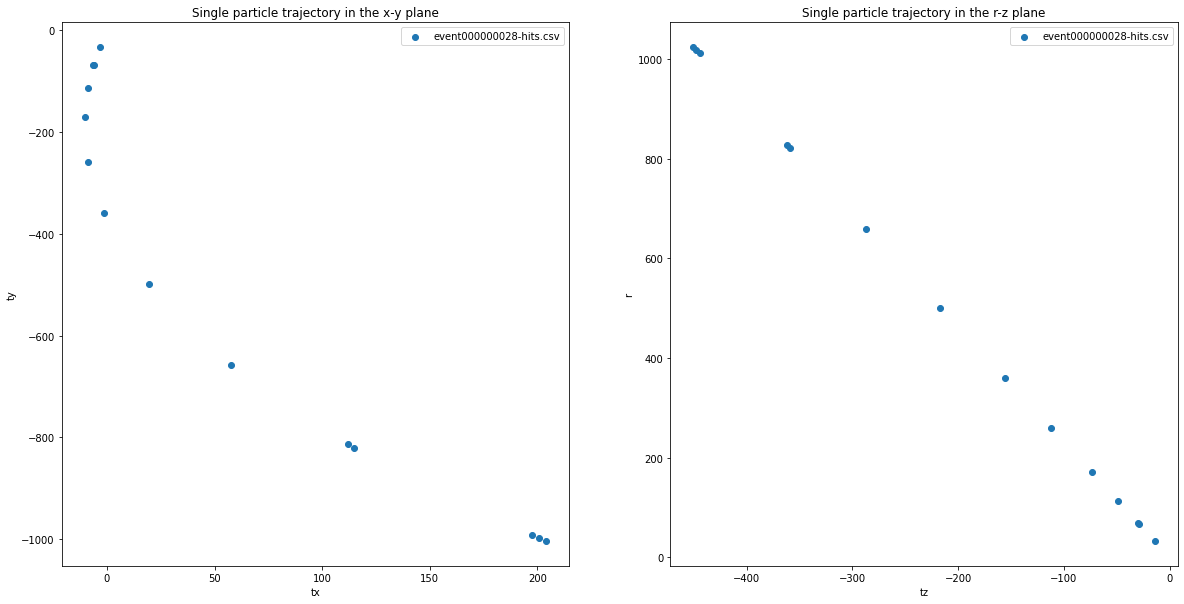

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.scatter(x=df['tx'], y=df['ty'], label=hit_files[random_event])
ax1.set_xlabel('tx')
ax1.set_ylabel('ty')
ax1.set_title('Single particle trajectory in the x-y plane')
ax1.legend(loc='best')

ax2.scatter(x=df['tz'], y=df['r'], label=hit_files[random_event])
ax2.set_xlabel('tz')
ax2.set_ylabel('r')
ax2.set_title('Single particle trajectory in the r-z plane')
ax2.legend(loc='best')

plt.show()

Let's define here the bin size and the range of search.

In [39]:
all_xy_tracks = list(df['xy_track'])
all_rz_tracks = list(df['rz_track'])

xy_bin_size = (0.001, 0.05)
xy_width_limits = (0, np.pi)
xy_x_range = np.arange(xy_width_limits[0], xy_width_limits[1], xy_bin_size[0])

rz_bin_size = (0.1, 0.1)
rz_width_limits = (-500, 500)
rz_x_range = np.arange(rz_width_limits[0], rz_width_limits[1], rz_bin_size[0])

Let's plot the tracks in the Hough Space.

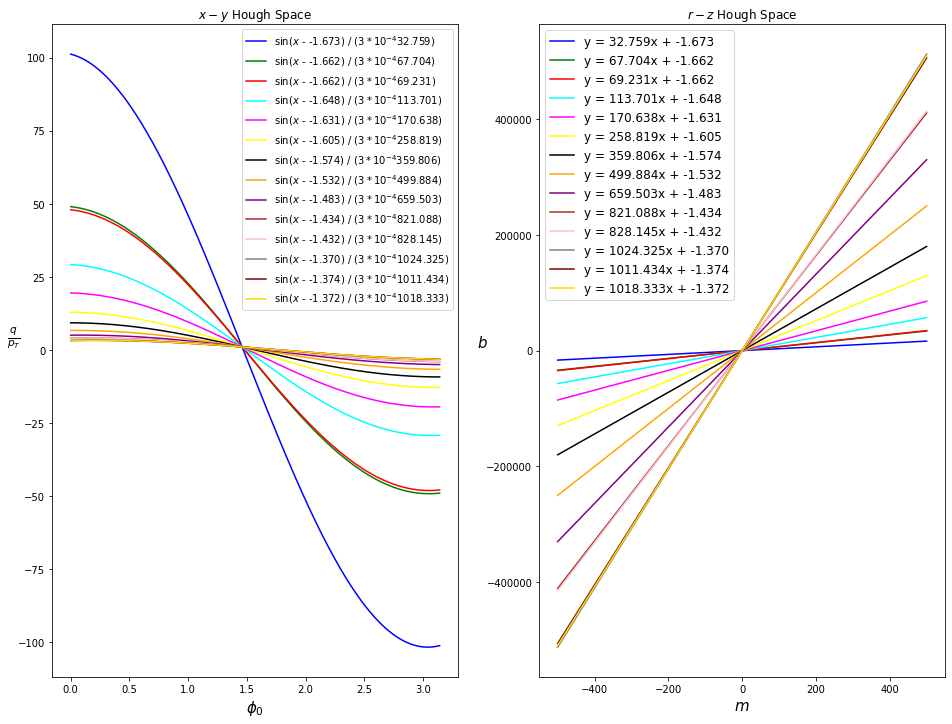

In [52]:
min_y, max_y = float('inf'), float('-inf')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 12))

# plot xy tracks
for idx, track in enumerate(all_xy_tracks):
    r, phi = track
    if use_sin:
        label = '$\sin$($x$ - ' + '{:.3f}'.format(phi) + ') / ($3*10^{-4}$' + '{:.3f}'.format(r) + ')'
    else:
        label = '($x$ - ' + '{:.3f}'.format(phi) + ') / ($3*10^{-4}$' + '{:.3f}'.format(r) + ')'
    ys = np.sin(xy_x_range - phi) / (A * r) if use_sin else (x_range - phi) / (A * r)
    min_y = min(np.min(ys), min_y)
    max_y = max(np.max(ys), max_y)
    ax1.plot(xy_x_range, ys, label=label, color=colors[idx % len(colors)])

ax1.set_xlabel('$\phi_0$', fontsize=15)
h = ax1.set_ylabel('$\\frac{q}{p_T}$', fontsize=15)
h.set_rotation(0)
ax1.set_title('$x-y$ Hough Space')
ax1.legend(loc='best', prop={'size': 10})


# plot rz tracks
for idx, track in enumerate(all_xy_tracks):
    r, z = track
    ys = r * rz_x_range + z
    label = f'y = {r:.3f}x + {z:.3f}'
    ax2.plot(rz_x_range, ys, label=label, color=colors[idx % len(colors)])

ax2.set_xlabel('$m$', fontsize=15)
h = ax2.set_ylabel('$b$', fontsize=15)
h.set_rotation(0)
ax2.set_title('$r-z$ Hough Space')
ax2.legend(loc='best', prop={'size': 12})
    
plt.show()

Let's run the pipeline and plot the results.

In [10]:
from notebook_utils import pipeline

height_limits = (min_y - 1, max_y + 1)
limits = (width_limits, height_limits)
selection_hyperparams = {'minimum-hits-per-bin': 10}

accumulator, est_tracks_to_hits = pipeline(all_tracks, bin_size, limits, selection_hyperparams, use_sin=use_sin)
len(est_tracks_to_hits)

3

Before plotting, let's define a RoI (Region of Interest) for the y-axis $\frac{q}{p_T}$ values, in order to make the heatmap more readable. I chose the interval $[-5, 3]$, but any other interval can be hard coded as well below.

In [11]:
lower_qpt = -5
upper_qpt = 3

low_qpt_bin = int((lower_qpt - height_limits[0] - 1e-12) / bin_size[1])
high_qpt_bin = int((upper_qpt - height_limits[0] - 1e-12) / bin_size[1])

roi_accumulator = accumulator[:, low_qpt_bin:high_qpt_bin]

low_qpt_bin, high_qpt_bin

(1691, 1851)

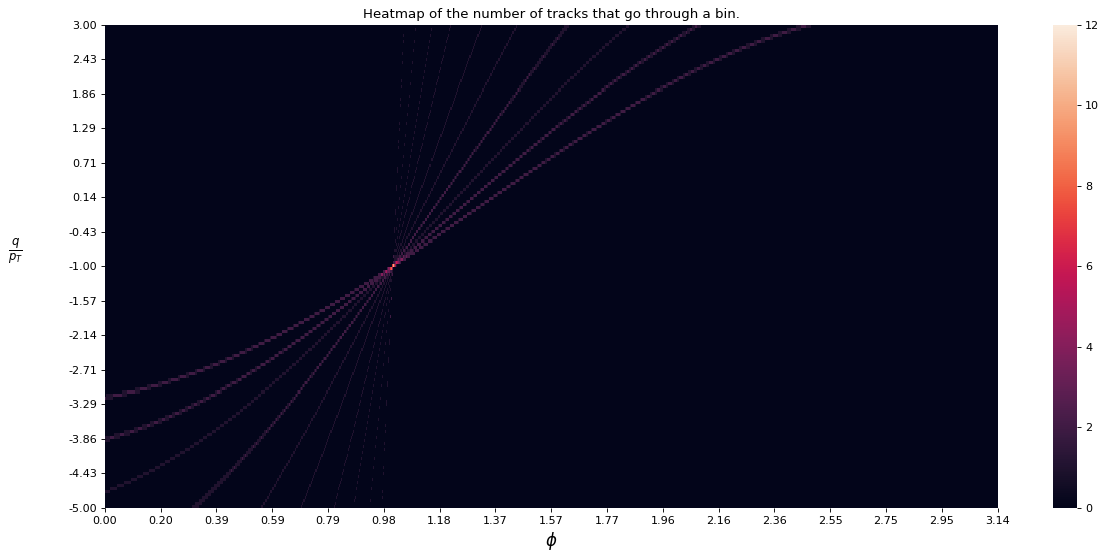

In [12]:
# size
plt.figure(figsize=(18, 8), dpi=80)

# x-axis ticks-labels
plt.locator_params(axis='x', nbins=17)
xticks = np.linspace(0, roi_accumulator.shape[0], 17)
x_range = np.linspace(width_limits[0], width_limits[1], xticks.shape[0])
xtick_labels = ['{:.2f}'.format(tick) for tick in x_range]

# y-axis ticks-labels
plt.locator_params(axis='y', nbins=15)
yticks = np.linspace(0, roi_accumulator.shape[1], 15)
y_range = np.linspace(lower_qpt, upper_qpt, yticks.shape[0])
ytick_labels = ['{:.2f}'.format(tick) for tick in y_range]

# heatmap
ax = sns.heatmap(roi_accumulator.T)

# config
ax.set_xlabel('$\phi$', fontsize=15)
h = ax.set_ylabel('$\\frac{q}{p_T}$', fontsize=15)
h.set_rotation(0)

ax.yaxis.set_label_coords(-0.1, 0.50)
ax.invert_yaxis()

ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels, rotation=0)

ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, rotation=0)

ax.set_title('Heatmap of the number of tracks that go through a bin.')

plt.show()

Let's cross check that the emittance angle $\phi_0$ falls in the right bin.